# Conjoint Analysis
The objective of this assignment is to give you experience with ratings-based conjoint analysis.
This project is done by a group students (Baron Wilton, Kaavash Bahl, Maghana Harish, Shiyue Ma, Shiyu Qian) at Duke's Fuqua School of Business MQM Program Market Intelligence Course

### Part 1: Study Design

Before this project, we designed a survey on Qualtrics. The goal of the survey is to find out customers's preferences for a healthy drink aternative. We asked customer questions regarding the size(12oz or 16oz), the ingredients(fruity or vegetable), source(organic or not organic). We collected the data based on survery responses.

In [1]:
# Import the experimental design builder script.
import sys
sys.path.insert(1, '/data/Assignment-4')
import designer
import pandas as pd
import numpy as np

**Task 1:** Define a variable called `attributes` that contains the attributes and levels within each attribute.  The viable shoukd be a dictionary where each attribute is a key and the value associated witht he key is a list of the levels.  For example, if the two attributes were color (with levels red and green) and shape (with levels round and square), then `attributes` would be defined as follows.

```
attributes = {"color": ["red", "green"],
             "shape": ["round", "square"]}
```

In [2]:
attributes = {"ingredients": ["fruit", "vegetable"],
              "size": (["12 oz"] + ["16 oz"]),
              "source": ["organic"] + ["not organic"]}

In [3]:
# Use the designer script to find a matching design.
design = designer.get_design(attributes)
design

,ingredients,size,source
0,fruit,16 oz,not organic
1,vegetable,16 oz,not organic
2,fruit,12 oz,not organic
3,fruit,12 oz,organic
4,vegetable,12 oz,organic
5,vegetable,16 oz,organic
6,vegetable,12 oz,not organic
7,fruit,16 oz,organic


In [4]:
product = [str(i) for i in range(1,9)]
design["product"] = product
design

,ingredients,size,source,product
0,fruit,16 oz,not organic,1
1,vegetable,16 oz,not organic,2
2,fruit,12 oz,not organic,3
3,fruit,12 oz,organic,4
4,vegetable,12 oz,organic,5
5,vegetable,16 oz,organic,6
6,vegetable,12 oz,not organic,7
7,fruit,16 oz,organic,8


### Parts 2 & 3: Write and administer the survey
**Task 2:** When you are done administering the survey:
- download CSV from qualtrics
- rename the file `survey.csv` and upload it here, and
- read the CSV file in as a pandas data frame called `raw_survey_results`.

In [6]:
raw_survey_results = pd.read_csv("survey.csv", header=1)

**Task 3:** Clean the data in preparation for analysis; name the clean data frame `clean_survey_results`.  You may need to do some or all of the following:
- remove rows and/or columns
- rename columns
- melt the data
- merge the data with the design data frame you created previously
The final data frame should have one row per rating with the following columns:
- some kind of respondent identifier to distinguish individuals
- the rating (0-7)
- one column for each attribute

In [7]:
clean_survey_results = raw_survey_results.drop(raw_survey_results.index[0])
clean_survey_results = clean_survey_results.drop(clean_survey_results.columns[0:8], axis=1)
clean_survey_results = clean_survey_results.drop(clean_survey_results.columns[1:9], axis=1)
clean_survey_results.columns = ['Response ID'] +([str(i) for i in range(1,9)])
clean_survey_results = clean_survey_results.replace(np.nan, '1', regex=True)
clean_survey_results = pd.melt(clean_survey_results, id_vars = ['Response ID'], 
                               var_name='product', value_name='rating')
clean_survey_results

,Response ID,product,rating
0,R_3g6CmSL8ZDx2q6E,1,2
1,R_3iOOvFVprNaIqVW,1,2
2,R_38bg3SAdQKLJh7z,1,3
3,R_1OB98CwBfhTtzKJ,1,6
4,R_wTATsopu0MvtZXr,1,4
...,...,...,...
155,R_1NwX8n1PHkTuCNG,8,3
156,R_3kjQSmwcI439U1o,8,5
157,R_3NwwMfBso8VCl6b,8,6
158,R_2ZNR7gO4zEULYH8,8,6


In [8]:
clean_survey_results = clean_survey_results.merge(design, on='product')
clean_survey_results = clean_survey_results.drop('product', axis=1)
clean_survey_results
clean_survey_results.head(5)

,Response ID,rating,ingredients,size,source
0,R_3g6CmSL8ZDx2q6E,2,fruit,16 oz,not organic
1,R_3iOOvFVprNaIqVW,2,fruit,16 oz,not organic
2,R_38bg3SAdQKLJh7z,3,fruit,16 oz,not organic
3,R_1OB98CwBfhTtzKJ,6,fruit,16 oz,not organic
4,R_wTATsopu0MvtZXr,4,fruit,16 oz,not organic


**Task 4:** Introduce dummy variables in preparation for anlaysis.  Now, for each attribute, there should be the number of levels minus one.  (The intercept captures the "default" level, and the part-worths for all other levels will be measured relative to the default utility.)

In [9]:
data = clean_survey_results

# default: fruit, 12 oz, organic
data['ingredients_alt'] = data['ingredients'] == "vegetable"
data['size_alt'] = data['size'] == "16 oz"
data['source_alt'] = data['source'] == "not organic"
data = data.drop(['ingredients', 'size', 'source'], axis=1)
data.head(5)

,Response ID,rating,ingredients_alt,size_alt,source_alt
0,R_3g6CmSL8ZDx2q6E,2,False,True,True
1,R_3iOOvFVprNaIqVW,2,False,True,True
2,R_38bg3SAdQKLJh7z,3,False,True,True
3,R_1OB98CwBfhTtzKJ,6,False,True,True
4,R_wTATsopu0MvtZXr,4,False,True,True


### Part 4: Estimate the average and individual part-worths

You will use [sklearn's implementation of linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to estimate part-worths.

In [10]:
from sklearn.linear_model import LinearRegression

**Task 5:** Compute the average part-worths by:
- splitting the data into `y` (the response/rating) and `X` (the explanatory variables/attribute levels), and
- Run a linear regression to estimate intercept and coefficients.

In [36]:
y = np.array(data.to_numpy()[:,1])
X = np.array(data.to_numpy()[:,2:], dtype=int)
reg = LinearRegression().fit(X, y)
intercept_avg = reg.intercept_
coef_avg = reg.coef_

print(reg.intercept_)
print(reg.coef_)

5.95
[-1.05  -0.475 -1.875]


**Task 6:** Calculate the importance of each attribute by doing the following steps.
1. Compute the part-worth range for each attribute. 
2. Calculate the total range, summing the ranges over each attribute.
3. Calculate the importance for a single attribute as the range for that attribute over the total range.

In [38]:
ingredients_partworths = [0, reg.coef_[0]]
range_ingredients = max(ingredients_partworths) - min(ingredients_partworths)

size_partworths = [0, reg.coef_[1]]
range_size = max(size_partworths) - min(size_partworths)

source_partworths = [0, reg.coef_[2]]
range_source = max(source_partworths) - min(source_partworths)

# sum all ranges
all_ranges = [range_ingredients, range_size, range_source]
sum(all_ranges)
print(all_ranges)

# calculate importance
all_ranges / sum(all_ranges)

[1.0499999999999998, 0.4749999999999994, 1.8750000000000013]


array([0.30882353, 0.13970588, 0.55147059])

**Task 7:** Now calculate individual part-worths.  You will do this by dividing up the data by individual respondent and running one regression for each respondent.  You should write a loop to iterate over all the respondents instead of doing each one manually.

You will want to create a data frame called `individual_part_worths` that has one row per individual respondent; the columns should be the respondent identifier, the intercept of the regression, and all the coefficients of the regression.

In [13]:
groups = []
intercepts = []
coefs = []

for (group, data_gp) in data.groupby("Response ID"):
    y = np.array(data_gp.to_numpy()[:,1])
    X = np.array(data_gp.to_numpy()[:,2:], dtype=int)
    reg = LinearRegression().fit(X, y)
    intercepts.append(reg.intercept_)
    coefs.append(reg.coef_)
    groups.append(group)

individual_part_worths = pd.DataFrame(coefs, columns=["coef_ing", "coef_size", "coef_sou"])
individual_part_worths["intercept"] = intercepts
individual_part_worths["id"] = groups
individual_part_worths

,coef_ing,coef_size,coef_sou,intercept,id
0,-1.570092e-16,0.000000e+00,-3.00,7.00,R_1BVl2Ljj1pAAQr8
1,-1.750000e+00,-2.250000e+00,-1.25,5.00,R_1NwX8n1PHkTuCNG
2,-2.750000e+00,2.500000e-01,-2.25,6.75,R_1OB98CwBfhTtzKJ
3,-7.500000e-01,-7.500000e-01,-1.25,6.00,R_1goxdeccKVZo4jN
4,-2.500000e+00,-5.551115e-17,-0.50,6.25,R_2QKko6eTPJs1E0X
5,-2.000000e+00,-5.000000e-01,-0.50,3.75,R_2QmIiQG3lvVbZBN
6,1.250000e+00,-2.500000e-01,-1.75,5.75,R_2ZNR7gO4zEULYH8
7,-1.750000e+00,-7.500000e-01,-1.75,6.75,R_2cbJw18kKuiJq80
8,-1.750000e+00,2.500000e-01,-1.75,6.50,R_2cvca5jZwbgU71K
9,7.850462e-17,-1.110223e-16,-1.00,7.00,R_2tn8z9maq1taPrd


**Task 8:** Create a visualization of the individual respondent coefficients and intercepts.  On the x axis should have categories for each of the level dummy variables and default; on the y-axis should be the part-worths (the values of the coefficients and the intercepts).  You should ploth both a summary of the part-worths (e.g., a violin plot, or box and whiskers) and the individual values.

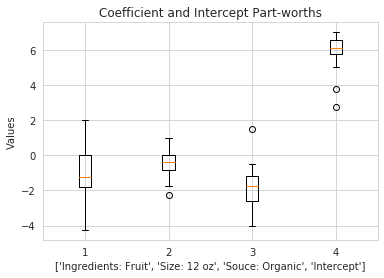

In [49]:
import matplotlib.pyplot as plt
# x axis values
x = ["Ingredients: Fruit","Size: 12 oz","Souce: Organic", "Intercept"]
# corresponding y axis values
y = [individual_part_worths.coef_ing, individual_part_worths.coef_size, individual_part_worths.coef_sou, individual_part_worths.intercept]
# plotting the points
plt.boxplot(individual_part_worths["coef_ing"], positions = [1])
plt.boxplot(individual_part_worths["coef_size"], positions = [2])
plt.boxplot(individual_part_worths["coef_sou"], positions = [3])
plt.boxplot(individual_part_worths["intercept"], positions = [4])
# naming the x axis
plt.xlabel(x)
# naming the y axis
plt.ylabel('Values')
# giving a title to my graph
plt.title('Coefficient and Intercept Part-worths')
# function to show the plot
plt.show()

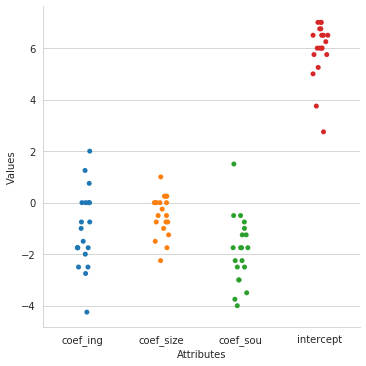

In [48]:
import seaborn as sns
sns.set_style("whitegrid")
g = sns.catplot(data = individual_part_worths.iloc[:,:4])
g.set_axis_labels("Attributes", "Values")
g.set_titles("Individual Part-worths")

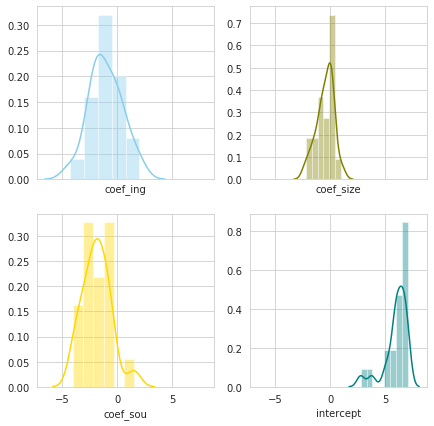

In [52]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.distplot(individual_part_worths["coef_ing"] , color="skyblue", ax=axes[0, 0])
sns.distplot(individual_part_worths["coef_size"], color="olive", ax=axes[0, 1])
sns.distplot(individual_part_worths["coef_sou"], color="gold", ax=axes[1, 0])
sns.distplot(individual_part_worths["intercept"], color="teal", ax=axes[1, 1])

### Part 5: Simulate the Market
**Task 9:** Write a function `utility` that takes two arguments:
- `product`: a list of which level has been selected for each attribute.  For example, if the two attributes were color (with levels red and green) and shape (with levels round and square), then `product` could take the value `["red", "square"]`.
- `part_worths`: a row from the `individual_part_worths` data frame created for Task 6 (i.e., one individual's part-worths) .

The `utility` function should compute and return the utility of the specified individual for the specified product; this is the intercept plus any relevant part-worths that correspond to the product's attribute levels.

In [16]:
def utility(products, part_worths):
    u = part_worths[3]
    if products[0] == "vegetable":
        u += part_worths[0]
    if products[1] == "16 oz":
        u += part_worths[1]
    if products[2] == "not organic":
        u += part_worths[2]
    return u

utility(["fruit", "12 oz", "not organic"], individual_part_worths.iloc[0,:])

3.999999999999999

In [22]:
# data_merge = data.merge(individual_part_worths, left_on="Response ID", right_on="id")

## getting the predicted score of each person to each product
# u_all = []
# for i in range(160):
#    y = data_merge.intercept[i] + data_merge.ingredients_alt[i]*data_merge.coef_ing[i] + data_merge.size_alt[i]*data_merge.coef_size[i] + data_merge.source_alt[i]*data_merge.coef_sou[i]    
#    u_all.append(y)

# print(u_all)

[2.5000000000000004, 1.7500000000000004, 2.2500000000000004, 6.0, 5.25, 5.5, 1.5000000000000004, 6.25, 2.4999999999999982, 0.9999999999999991, 3.999999999999999, 6.5, 5.000000000000001, 3.5, 2.5, 4.999999999999999, 2.9999999999999982, 1.2499999999999987, 4.75, 7.0, 5.25, 3.4999999999999987, 3.0, 5.249999999999998, 4.750000000000001, 2.000000000000001, 4.500000000000001, 6.75, 4.0, 4.25, 1.7500000000000009, 7.0, 4.5, 0.25, 5.75, 6.5, 2.25, 0.9999999999999998, 1.5000000000000002, 5.25, 5.0, 3.25, 4.75, 6.5, 4.75, 5.0, 3.0, 6.75, 2.7500000000000004, 3.4999999999999987, 3.5000000000000004, 5.25, 5.999999999999999, 5.249999999999998, 4.25, 4.5, 3.4999999999999996, 3.4999999999999996, 3.9999999999999996, 6.5, 6.5, 6.0, 3.9999999999999996, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 6.0, 7.0, 2.75, 0.7500000000000001, 3.25, 3.75, 1.7500000000000004, 1.2500000000000002, 1.2500000000000004, 3.25, 4.25, 2.5, 5.0, 6.75, 5.0, 4.25, 3.25, 6.0, 5.75, 3.25, 5.75, 6.25, 3.75, 3.75, 3.25, 6.25, 3.99999999999999

**Task 10:** Write a function `choose_product` that takes two arguments:
- `products`: a list of products, where each product is its own list as specified in Task 8, (Yes, it's a list of lists!)
- `part_worths`: a row of inidivudual part worths, just as used in Task 8.

This fuction should return a numpy array with the same length as the number of products; this array should contain a boolean value (true or false) for each product.  The value for a product should be true if it maximizes the utility for the individual; as multiple products can have equivalent utilities, more than one product might maximize utility.

As an example, if there are two products, the `choose_product` function could return `[True, False]` if the first product maximizes the utility, `[False, True]` if the second product maximizes utility, or `[True, True]` if both products have the same utility and therefor both maximize utility for specified the individual.

In [17]:
def choose_product(products, part_worths):
    ui = []
    for i in range(len(products)):
        ui.append(utility(products[i], part_worths))
    result = []
    for u in range(len(ui)):
        result.append(ui[u] == max(ui))
    return result

choose_product([["fruit", "12 oz", "not organic"], ["fruit", "16 oz", "organic"], ["vegetable", "12 oz", "organic"]], individual_part_worths.iloc[0,:])

[False, True, True]

**Task 11:** Write a function `simulate` that takes two arguments:
- `products`: a list of products, identitcal to the argument for Task 9.
- The `individual_part_worths` data frame created for Task 7.

This function should simulate the market share of the products by having each individual choose a product from the list.  For an individual who chooses more than one item (multiple items are tied for the top utility value), their "vote" is split between the tied items.  The function should return an array of proportions of market share.  

In [50]:
design

,ingredients,size,source,product
0,fruit,16 oz,not organic,1
1,vegetable,16 oz,not organic,2
2,fruit,12 oz,not organic,3
3,fruit,12 oz,organic,4
4,vegetable,12 oz,organic,5
5,vegetable,16 oz,organic,6
6,vegetable,12 oz,not organic,7
7,fruit,16 oz,organic,8


In [18]:
products_full = []
for i in range(len(design)):
    p = []
    ing = design.iloc[i,0]
    size = design.iloc[i,1]
    sou = design.iloc[i,2]
    p.append(ing)
    p.append(size)
    p.append(sou)
    products_full.append(p)

products_full

[['fruit', '16 oz', 'not organic'],
 ['vegetable', '16 oz', 'not organic'],
 ['fruit', '12 oz', 'not organic'],
 ['fruit', '12 oz', 'organic'],
 ['vegetable', '12 oz', 'organic'],
 ['vegetable', '16 oz', 'organic'],
 ['vegetable', '12 oz', 'not organic'],
 ['fruit', '16 oz', 'organic']]

In [25]:
result_full = []
for i in range(len(individual_part_worths)):
    result_full.append(choose_product(products_full, individual_part_worths.iloc[i,:]))

result_full = pd.DataFrame(result_full)
result_full

,0,1,2,3,4,5,6,7
0,False,False,False,True,True,True,False,True
1,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,True
3,False,False,False,True,False,False,False,False
4,False,False,False,True,False,False,False,True
5,False,False,False,True,False,False,False,False
6,False,False,False,False,True,False,False,False
7,False,False,False,True,False,False,False,False
8,False,False,False,False,False,False,False,True
9,False,False,False,True,True,True,False,True


In [26]:
for n in range(len(20)):
    sum_row = sum(result_full.iloc[n,:]) 
    for m in range(0,8):
        result_full.iloc[n,m] = result_full.iloc[n,m] / sum_row         

result_full

,0,1,2,3,4,5,6,7
0,0,0,0,0.25,0.25,0.25,0,0.25
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0
4,0,0,0,0.5,0,0,0,0.5
5,0,0,0,1,0,0,0,0
6,0,0,0,0,1,0,0,0
7,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,1
9,0,0,0,0.25,0.25,0.25,0,0.25


In [49]:
mkt_share =[]
for i in range(8):
    mkt_share.append(sum(result_full.iloc[:,i])/20)   

mkt_share

[0.025, 0.0, 0.025, 0.45, 0.2, 0.05, 0.0, 0.25]

In [19]:
def simulate(products, individual_part_worths):
    result_full = []
    for i in range(len(individual_part_worths)):
        result_full.append(choose_product(products_full, individual_part_worths.iloc[i,:]))
        df = pd.DataFrame(result_full)
    for n in range(20):
        sum_row = sum(df.iloc[n,:])
        for m in range(8):
            df.iloc[n,m] = df.iloc[n,m] / sum_row 
    mkt_share =[]
    for i in range(8):
        mkt_share.append(sum(df.iloc[:,i])/20)   
    index = products_full.index(products)
    return(mkt_share[index])

In [20]:
simulate(['fruit', '16 oz', 'not organic'], individual_part_worths)

0.025

**Task 12:** Create a variable called `my_product` that has the ideal value (maximum average utility) based on what you discovered in Task 5; this should be in the format described in Task 9.  For example, if the two attributes were color (with levels red and green) and shape (with levels round and square), then `my_product` could take the value `["red", "square"]`.  Also create three competitiors (e.g., `competitor1`) using this same format.  Create a list called `all_products` that contains all four products and simulate the market with the products.

In [21]:
print(intercept_avg)
print(coef_avg)

5.95
[-1.05  -0.475 -1.875]


In [22]:
def utility_avg(ingredients_alt, size_alt, source_alt):
    u = intercept_avg
    if ingredients_alt:
        u += coef_avg[0]
    if size_alt:
        u += coef_avg[1]
    if source_alt:
        u +=  coef_avg[2]
    return u

In [23]:
max_utility = 0
my_product = ""

for ingredients_alt in [True, False]:
    for size_alt in [True, False]:
        for source_alt in [True, False]:
            u = utility_avg(ingredients_alt, size_alt, source_alt)
            if u > max_utility:
                max_utility = u
                my_product = (ingredients_alt, size_alt, source_alt)

my_product = ("vegetable" if my_product[0] else "fruit") + ',' + \
    ("16 oz" if my_product[0] else "12 oz") + ',' + \
    ("not organic" if my_product[0] else "organic")

my_product = my_product.split(",")

list(my_product)
my_product

['fruit', '12 oz', 'organic']

In [24]:
competitor1 = []
competitor1.append(["fruit", "16 oz", "organic"])
competitor1.append(["vegetable", "12 oz", "organic"])
competitor1.append(["vegetable", "16 oz", "organic"])

all_products = competitor1
all_products.append(my_product)

ms = []
for product in all_products:
    ms.append(simulate(product, individual_part_worths))

ms   

[0.25, 0.2, 0.05, 0.45]

**Task 13:** Redefine `my_product` such that the most important attribute (from Task 6) now has the least liked level (per what you found in Task 5) and rerun the market simulation keeping the competitors the same.

In [39]:
my_product = ["fruit", "12 oz", "not organic"]
my_product

['fruit', '12 oz', 'not organic']

In [40]:
competitor1 = []
competitor1.append(["fruit", "16 oz", "organic"])
competitor1.append(["vegetable", "12 oz", "organic"])
competitor1.append(["vegetable", "16 oz", "organic"])

all_products = competitor1
all_products.append(my_product)

ms = []
for product in all_products:
    ms.append(simulate(product, individual_part_worths))

ms 

[0.25, 0.2, 0.05, 0.025]